In [1]:

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
from tabulate import tabulate
import networkx as nx
import community.community_louvain as community_louvain

file_path = "/content/retail_data.csv"
df = pd.read_csv(file_path, low_memory=False)

print("Shape of dataset (rows, cols):", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nData types info:\n")
print(df.info())

print("\nMissing values per column:\n")
print(df.isnull().sum().sort_values(ascending=False))

before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"\n Dropped {before - after} duplicate rows (based on all columns).")

critical_cols = ['Customer_ID', 'Transaction_ID', 'Amount', 'Product_Category']
df = df.dropna(subset=[col for col in critical_cols if col in df.columns])
print(f" Rows after dropping missing critical values: {df.shape[0]}")

for id_col in ['Customer_ID', 'Transaction_ID', 'Phone', 'Zipcode']:
    if id_col in df.columns:
        df[id_col] = df[id_col].astype(str).str.replace('.0', '', regex=False)

for num_col in ['Amount', 'Total_Amount', 'Ratings', 'Age', 'Total_Purchases']:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors='coerce')

df['Date'] = pd.to_datetime(df['Date'], format='mixed')
import calendar

df.loc[df['Year'].isna() & df['Date'].notna(), 'Year'] = df['Date'].dt.year

df.loc[df['Month'].isna() & df['Date'].notna(), 'Month'] = df['Date'].dt.month_name()

mask = df['Date'].isna() & df['Year'].notna() & df['Month'].notna()
if mask.any():
    def rebuild_date(row):
        try:
            m = row['Month']
            if isinstance(m, str):
                m = list(calendar.month_name).index(m)
            return pd.to_datetime(f"{int(row['Year'])}-{int(m):02d}-01")
        except:
            return pd.NaT
    df.loc[mask, 'Date'] = df.loc[mask].apply(rebuild_date,axis=1)
if 'Amount' in df.columns:
    df = df[df['Amount'] > 0]
print(f" Rows after removing invalid Amounts: {df.shape[0]}")

print("\n Numeric Summary:\n", df.describe())
print("\n Categorical Summary:\n", df.describe(include=['object']))

df.to_csv("/content/retail_data_cleaned.csv", index=False)
print("\n Cleaned dataset saved as 'retail_data_cleaned.csv'")


Shape of dataset (rows, cols): (302010, 30)

Column names:
 ['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address', 'City', 'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income', 'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases', 'Amount', 'Total_Amount', 'Product_Category', 'Product_Brand', 'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status', 'Ratings', 'products']

Data types info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302010 entries, 0 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    301677 non-null  float64
 1   Customer_ID       301702 non-null  float64
 2   Name              301628 non-null  object 
 3   Email             301663 non-null  object 
 4   Phone             301648 non-null  float64
 5   Address           301695 non-null  object 
 6   City              301762 non-null  object 
 7

In [2]:

df = pd.read_csv("/content/retail_data_cleaned.csv")


if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])



# Average Order Value (AOV)
if "Total_Amount" in df.columns and "Total_Purchases" in df.columns:
    df["AOV"] = df["Total_Amount"] / df["Total_Purchases"].replace(0, np.nan)

# Recency (days since last purchase, relative to max date)
if "Date" in df.columns:
    max_date = df["Date"].max()
    df["Recency"] = (max_date - df["Date"]).dt.days

# Frequency (approximation: purchases per year based on available period)
if "Total_Purchases" in df.columns and "Date" in df.columns:
    customer_first_last = df.groupby("Customer_ID")["Date"].agg(["min", "max"]).reset_index()
    customer_first_last["Tenure_days"] = (customer_first_last["max"] - customer_first_last["min"]).dt.days + 1
    df = df.merge(customer_first_last[["Customer_ID", "Tenure_days"]], on="Customer_ID", how="left")
    df["Frequency"] = df["Total_Purchases"] / (df["Tenure_days"] / 365).replace(0, np.nan)

# Customer Lifetime Value (approximation)
if "AOV" in df.columns and "Total_Purchases" in df.columns:
    df["CLV"] = df["AOV"] * df["Total_Purchases"]

# Customer Tenure (days active in system)
if "Tenure_days" in df.columns:
    df["Tenure"] = df["Tenure_days"]

# Average Spend per Month
if "Total_Amount" in df.columns and "Tenure_days" in df.columns:
    df["AvgMonthlySpend"] = df["Total_Amount"] / (df["Tenure_days"] / 30).replace(0, np.nan)


# Category Preference Index (per customer share of category)
if "Product_Category" in df.columns and "Total_Purchases" in df.columns:
    cat_counts = df.groupby(["Customer_ID", "Product_Category"])["Total_Purchases"].sum().reset_index()
    total_counts = df.groupby("Customer_ID")["Total_Purchases"].sum().reset_index().rename(columns={"Total_Purchases":"TotalCustPurchases"})
    cat_pref = pd.merge(cat_counts, total_counts, on="Customer_ID", how="left")
    cat_pref["CategoryPrefIndex"] = cat_pref["Total_Purchases"] / cat_pref["TotalCustPurchases"]
    df = df.merge(cat_pref[["Customer_ID","Product_Category","CategoryPrefIndex"]],
                  on=["Customer_ID","Product_Category"], how="left")

# Brand Loyalty Index
if "Product_Brand" in df.columns and "Total_Purchases" in df.columns:
    brand_counts = df.groupby(["Customer_ID","Product_Brand"])["Total_Purchases"].sum().reset_index()
    brand_loyalty = brand_counts.groupby("Customer_ID")["Total_Purchases"].max().reset_index().rename(columns={"Total_Purchases":"MaxBrandPurchases"})
    total_counts = df.groupby("Customer_ID")["Total_Purchases"].sum().reset_index().rename(columns={"Total_Purchases":"TotalCustPurchases"})
    loyalty = pd.merge(brand_loyalty, total_counts, on="Customer_ID")
    loyalty["BrandLoyaltyIndex"] = loyalty["MaxBrandPurchases"] / loyalty["TotalCustPurchases"]
    df = df.merge(loyalty[["Customer_ID","BrandLoyaltyIndex"]], on="Customer_ID", how="left")

# High-Value Product Flag
if "Amount" in df.columns and "Product_Category" in df.columns:
    high_value_threshold = df.groupby("Product_Category")["Amount"].transform(lambda x: x.mean() + 2*x.std())
    df["HighValueFlag"] = (df["Amount"] > high_value_threshold).astype(int)

# Cancellation Rate per Customer
if "Order_Status" in df.columns:
    cancel_rate = df.groupby("Customer_ID")["Order_Status"].apply(lambda x: (x=="Canceled").sum()/len(x)).reset_index().rename(columns={"Order_Status":"CancellationRate"})
    df = df.merge(cancel_rate, on="Customer_ID", how="left")

# Preferred Shipping Method
if "Shipping_Method" in df.columns:
    ship_pref = df.groupby("Customer_ID")["Shipping_Method"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index().rename(columns={"Shipping_Method":"PreferredShipping"})
    df = df.merge(ship_pref, on="Customer_ID", how="left")

# Payment Diversity Score
if "Payment_Method" in df.columns:
    pay_div = df.groupby("Customer_ID")["Payment_Method"].nunique().reset_index().rename(columns={"Payment_Method":"PaymentDiversity"})
    df = df.merge(pay_div, on="Customer_ID", how="left")

# Delivery Success Rate
if "Order_Status" in df.columns:
    delivery_rate = df.groupby("Customer_ID")["Order_Status"].apply(lambda x: (x=="Delivered").sum()/len(x)).reset_index().rename(columns={"Order_Status":"DeliveryRate"})
    df = df.merge(delivery_rate, on="Customer_ID", how="left")

# Churn Risk Score (simple rule: high recency + low frequency + low monetary)
if "Recency" in df.columns and "Frequency" in df.columns and "Total_Amount" in df.columns:
    df["ChurnRiskScore"] = (
        (df["Recency"].rank(pct=True)) +
        (1 - df["Frequency"].rank(pct=True)) +
        (1 - df["Total_Amount"].rank(pct=True))
    ) / 3

df.to_csv("/content/retail_data_engineered.csv", index=False)
print(" Engineered dataset saved as 'retail_data_engineered.csv'")
print("Final shape:", df.shape)
print("New columns added:")
print([col for col in df.columns if col not in ['Transaction_ID','Customer_ID','Name','Email','Phone','Address','City','State','Zipcode','Country','Age','Gender','Income','Customer_Segment','Date','Year','Month','Time','Total_Purchases','Amount','Total_Amount','Product_Category','Product_Brand','Product_Type','Feedback','Shipping_Method','Payment_Method','Order_Status','Ratings','products']])
edf = pd.read_csv("/content/retail_data_engineered.csv")

 Engineered dataset saved as 'retail_data_engineered.csv'
Final shape: (300727, 45)
New columns added:
['AOV', 'Recency', 'Tenure_days', 'Frequency', 'CLV', 'Tenure', 'AvgMonthlySpend', 'CategoryPrefIndex', 'BrandLoyaltyIndex', 'HighValueFlag', 'CancellationRate', 'PreferredShipping', 'PaymentDiversity', 'DeliveryRate', 'ChurnRiskScore']


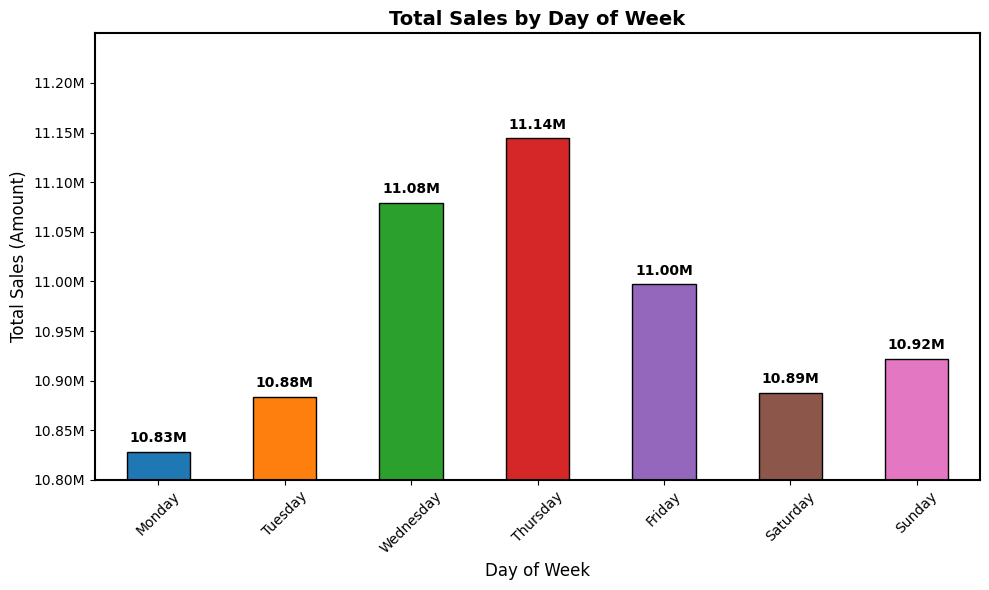

In [3]:
#1 Total Sales by Day of Week
df['Day_of_Week'] = df['Date'].dt.day_name()

day_sales = df.groupby('Day_of_Week')['Amount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

fig, ax = plt.subplots(figsize=(10,6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c',
          '#d62728', '#9467bd', '#8c564b', '#e377c2']

day_sales.plot(kind='bar', color=colors, edgecolor='black', ax=ax)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height()/1e6:.2f}M',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10), textcoords='offset points',
        fontsize=10, fontweight='bold', color='black'
    )

ax.set_title("Total Sales by Day of Week", fontsize=14, fontweight='bold')
ax.set_xlabel("Day of Week", fontsize=12)
ax.set_ylabel("Total Sales (Amount)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.set_ylim(10_800_000, 11_250_000)

yticks = list(np.arange(10_800_000, 11_250_000, 50_000))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(y/1e6)}M" for y in yticks])

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.2f}M"))

ax.grid(axis='y', linestyle='--', alpha=0.6)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.tight_layout()
plt.show()


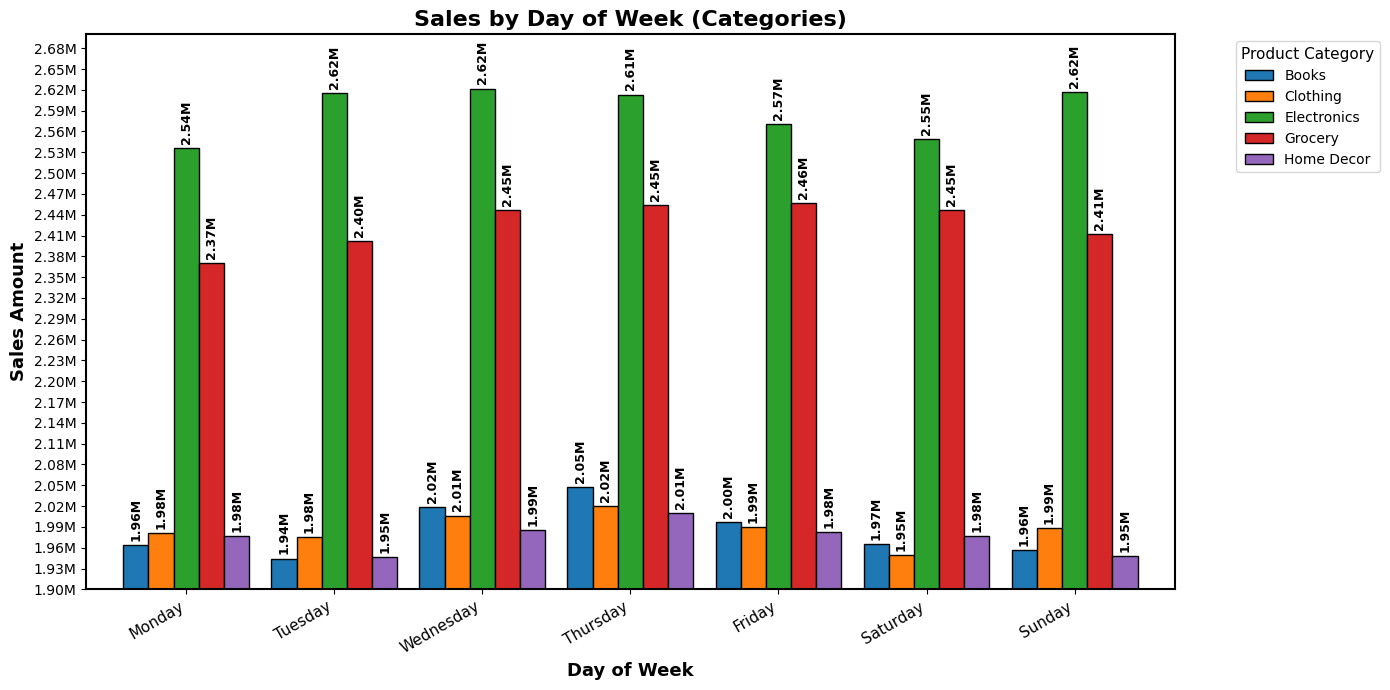

In [4]:
#2 Sales of Categories by Day of Week
df["DayOfWeek"] = df["Date"].dt.day_name()

day_cat_sales = (
    df.groupby(["DayOfWeek", "Product_Category"])["Amount"]
    .sum()
    .unstack(fill_value=0)
)

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_cat_sales = day_cat_sales.reindex(days_order)

colors = sns.color_palette("tab10", n_colors=len(day_cat_sales.columns))
fig, ax = plt.subplots(figsize=(14,7))

day_cat_sales.plot(
    kind="bar",
    ax=ax,
    color=colors,
    width=0.85,
    edgecolor="black"
)

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v/1e6:.2f}M" if v > 0 else "" for v in container.datavalues],
        label_type="edge",
        fontsize=9, fontweight="bold", color="black",
        rotation=90, padding=3
    )

ax.set_ylim(1_900_000, 2_700_000)

yticks = list(np.arange(1_900_000, 2_700_000, 30_000))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(y/1e6)}M" for y in yticks])

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.2f}M"))

ax.set_title("Sales by Day of Week (Categories)", fontsize=16, fontweight="bold")
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Sales Amount", fontsize=13, fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

ax.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, title_fontsize=11)
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.tight_layout()
plt.show()


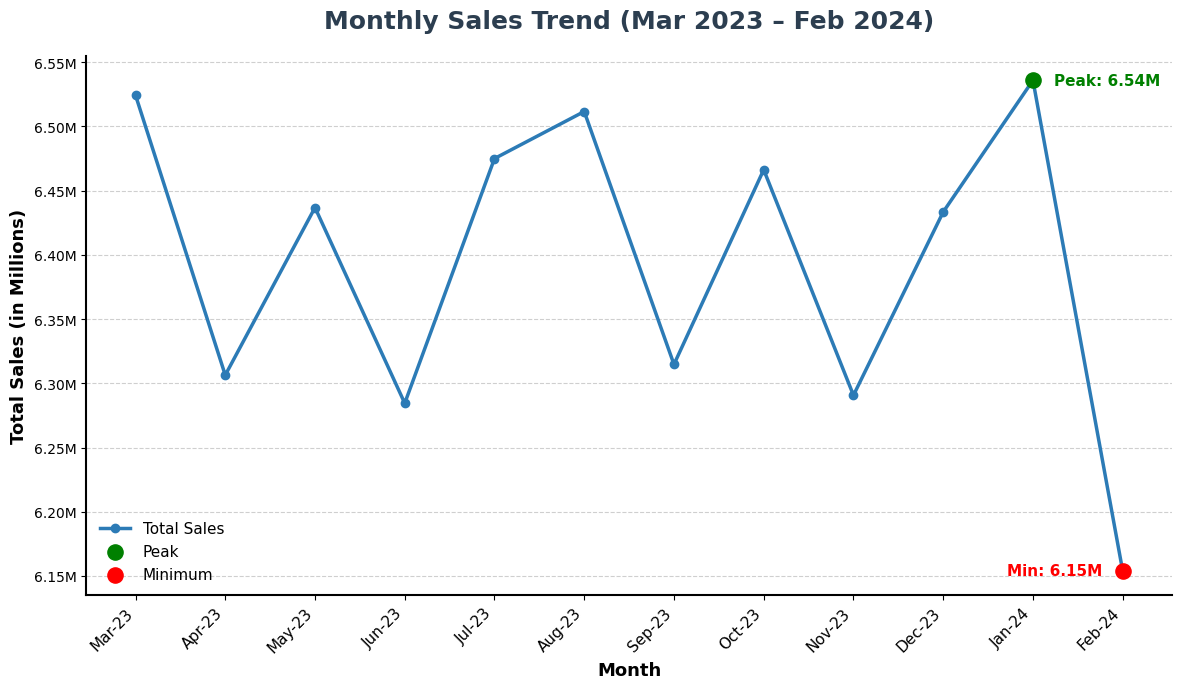

In [5]:
#3 Monthly Sales Trend (Mar 2023 - Feb 2024)

df['Date'] = pd.to_datetime(df['Date'])
start_date = '2023-03-01'
end_date = '2024-02-29'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]

monthly_sales = (
    filtered_df.groupby(filtered_df['Date'].dt.strftime('%Y-%m'))['Amount']
    .sum()
    .reset_index()
    .rename(columns={'Date': 'YearMonth'})
)

peak_point = monthly_sales.loc[monthly_sales['Amount'].idxmax()]
min_point = monthly_sales.loc[monthly_sales['Amount'].idxmin()]

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    monthly_sales['YearMonth'],
    monthly_sales['Amount'],
    marker='o',
    linewidth=2.5,
    color='#2C7BB6',
    zorder=3,
    label="Total Sales"
)

ax.scatter(peak_point['YearMonth'], peak_point['Amount'], color="green", s=120, zorder=4, label="Peak")
ax.scatter(min_point['YearMonth'], min_point['Amount'], color="red", s=120, zorder=4, label="Minimum")

ax.annotate(
    f"Peak: {peak_point['Amount']/1e6:.2f}M",
    xy=(peak_point['YearMonth'], peak_point['Amount']),
    xytext=(15, 0),
    textcoords="offset points",
    ha="left", va="center", fontsize=11, fontweight="bold", color="green"
)

ax.annotate(
    f"Min: {min_point['Amount']/1e6:.2f}M",
    xy=(min_point['YearMonth'], min_point['Amount']),
    xytext=(-15, 0),
    textcoords="offset points",
    ha="right", va="center", fontsize=11, fontweight="bold", color="red"
)

ax.set_title("Monthly Sales Trend (Mar 2023 – Feb 2024)", fontsize=18, fontweight='bold', pad=20, color="#2c3e50")
ax.set_xlabel("Month", fontsize=13, fontweight='bold')
ax.set_ylabel("Total Sales (in Millions)", fontsize=13, fontweight='bold')

month_labels = [pd.to_datetime(d).strftime('%b-%y') for d in monthly_sales['YearMonth']]
ax.set_xticks(monthly_sales['YearMonth'])
ax.set_xticklabels(month_labels, rotation=45, ha='right', fontsize=11)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.2f}M'))

ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False, fontsize=11)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
fig.tight_layout()

plt.show()


In [18]:
#4 Total Sales by U.S. State (Map)


usa_df = df[df["Country"] == "USA"].copy()

state_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}

usa_df["State_Code"] = usa_df["State"].map(state_abbrev)
usa_df = usa_df.dropna(subset=["State_Code"])

state_sales = usa_df.groupby(["State", "State_Code"], as_index=False)["Total_Amount"].sum()

min_val = state_sales["Total_Amount"].min()
max_val = state_sales["Total_Amount"].max()


fig = px.choropleth(
    state_sales,
    locations="State_Code",
    locationmode="USA-states",
    color="Total_Amount",
    scope="usa",
    color_continuous_scale="YlOrRd",
    range_color=[min_val, min_val + 500000],
    title="Total Sales by U.S. State"
)

table_df = state_sales[["State_Code", "State", "Total_Amount"]] \
    .assign(Total_Amount=lambda x: (x["Total_Amount"] / 1_000_000).round(2).astype(str) + "M") \
    .sort_values("Total_Amount", ascending=False)

print("\n Total Sales by State:\n")
print(tabulate(table_df.values, headers=table_df.columns, tablefmt="pretty", stralign="center", numalign="center"))

fig.show()




 Total Sales by State:

+------------+----------------+--------------+
| State_Code |     State      | Total_Amount |
+------------+----------------+--------------+
|     KS     |     Kansas     |    7.32M     |
|     NM     |   New Mexico   |    7.08M     |
|     CT     |  Connecticut   |    29.26M    |
|     ME     |     Maine      |    16.48M    |
|     GA     |    Georgia     |    12.94M    |
|     WV     | West Virginia  |     1.3M     |
|     NY     |    New York    |    1.38M     |
|     TX     |     Texas      |    1.37M     |
|     IA     |      Iowa      |    1.35M     |
|     MS     |  Mississippi   |    1.33M     |
|     IN     |    Indiana     |     1.2M     |
|     RI     |  Rhode Island  |     1.2M     |
|     NE     |    Nebraska    |     1.2M     |
|     IL     |    Illinois    |    1.29M     |
|     MD     |    Maryland    |    1.29M     |
|     DE     |    Delaware    |    1.28M     |
|     PA     |  Pennsylvania  |    1.28M     |
|     OH     |      Ohio      |    

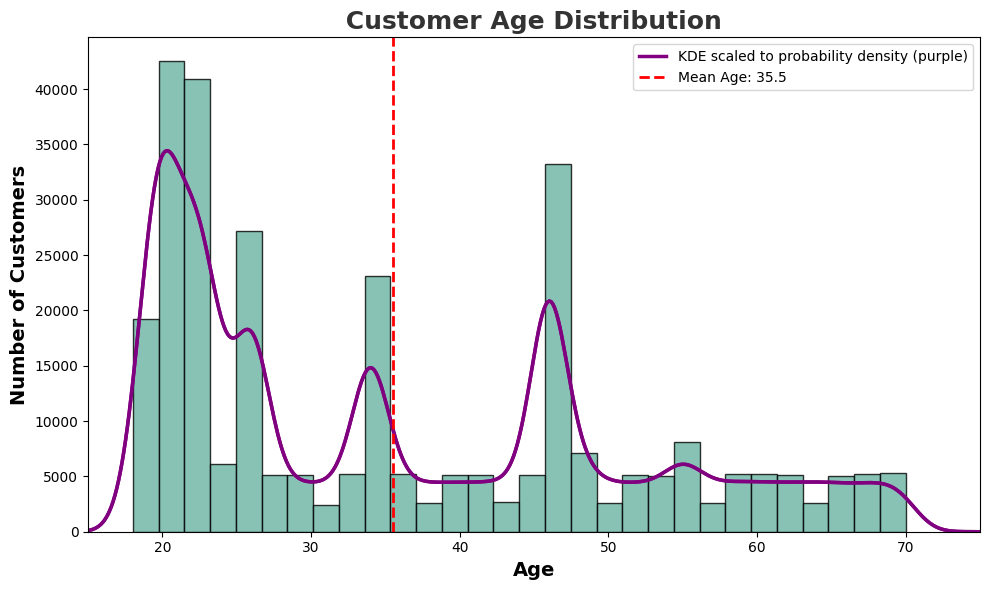

In [7]:
#5 Customer Age Distribution
age = df['Age'].dropna().values
fig, ax = plt.subplots(figsize=(10,6))
counts, bins, patches = ax.hist(age, bins=30, density=False, color="#69b3a2", edgecolor="black", alpha=0.8)
kde = gaussian_kde(age)
xs = np.linspace(15, 75, 500)
dx = bins[1] - bins[0]
kde_vals = kde(xs) * len(age) * dx
ax.plot(xs, kde_vals, color='purple', linewidth=2.5)

ax.plot(xs, kde_vals, color='purple', linewidth=2.5, label='KDE scaled to probability density (purple)')

mean_age = age.mean()
ax.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f"Mean Age: {mean_age:.1f}")

for spine in ax.spines.values():
    spine.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.title(" Customer Age Distribution ", fontsize=18, fontweight='bold', color="#333333")
plt.xlabel("Age", fontsize=14, fontweight='bold')
plt.ylabel("Number of Customers", fontsize=14, fontweight='bold')

ax.set_xlim(15,75)
ax.legend()
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.tight_layout()
plt.show()


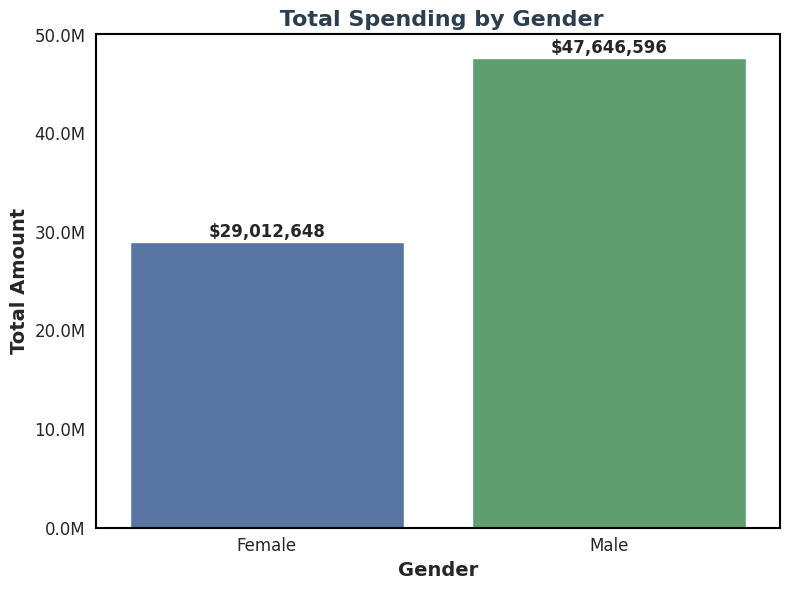

In [8]:

#6 Total Spending by Gender
gender_spending = df.groupby("Gender")["Amount"].sum().reset_index()
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(
    x="Gender",
    y="Amount",
    data=gender_spending,
    palette=["#4C72B0", "#55A868"],
    hue="Gender",
    legend=False
)

for index, row in gender_spending.iterrows():
    plt.text(
        x=index,
        y=row["Amount"] + gender_spending["Amount"].max()*0.01,
        s=f"${int(row['Amount']):,}",
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title(" Total Spending by Gender", fontsize=16, fontweight='bold', color="#2c3e50")
plt.xlabel("Gender", fontsize=14, fontweight='bold')
plt.ylabel("Total Amount", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))


for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.tight_layout()
plt.show()


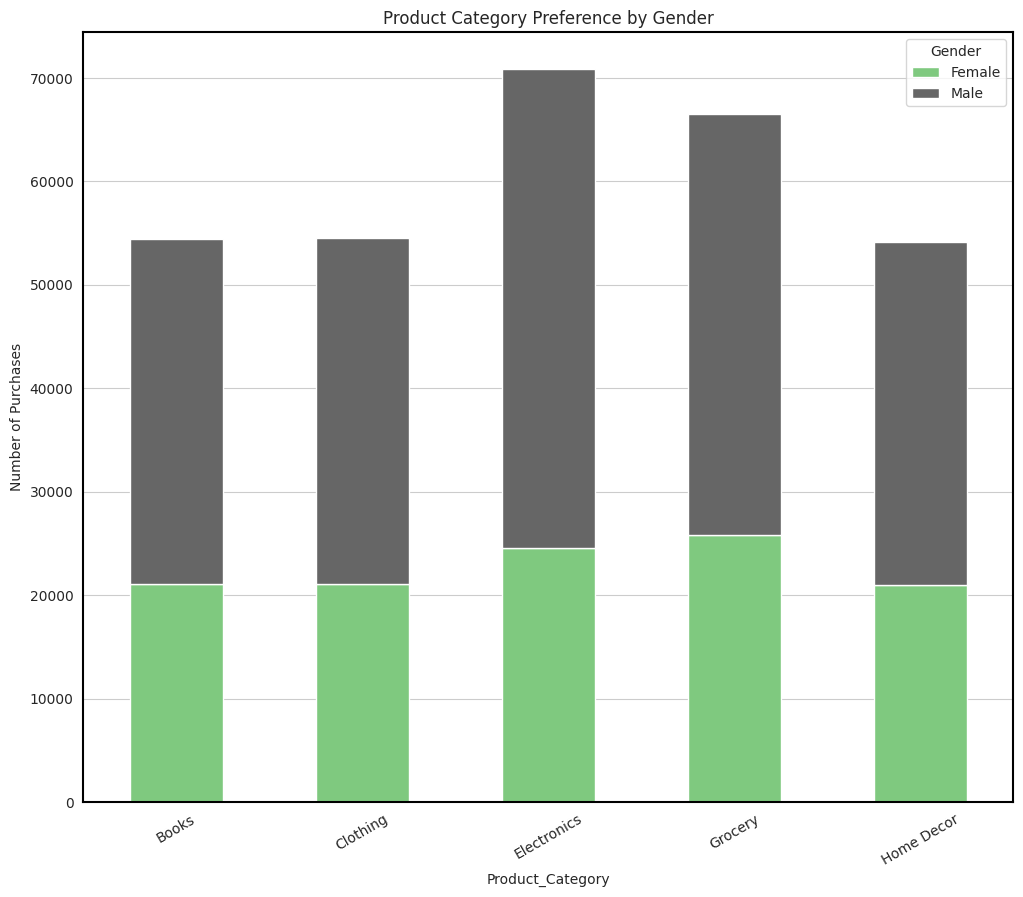

In [9]:
#7 Product Category Preference by Gender
cat_gender = df.groupby(["Product_Category","Gender"]).size().unstack()
cat_gender.plot(kind="bar", stacked=True, colormap="Accent", figsize=(12,10))
plt.title("Product Category Preference by Gender")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=30)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.grid(False, axis='x')
plt.show()

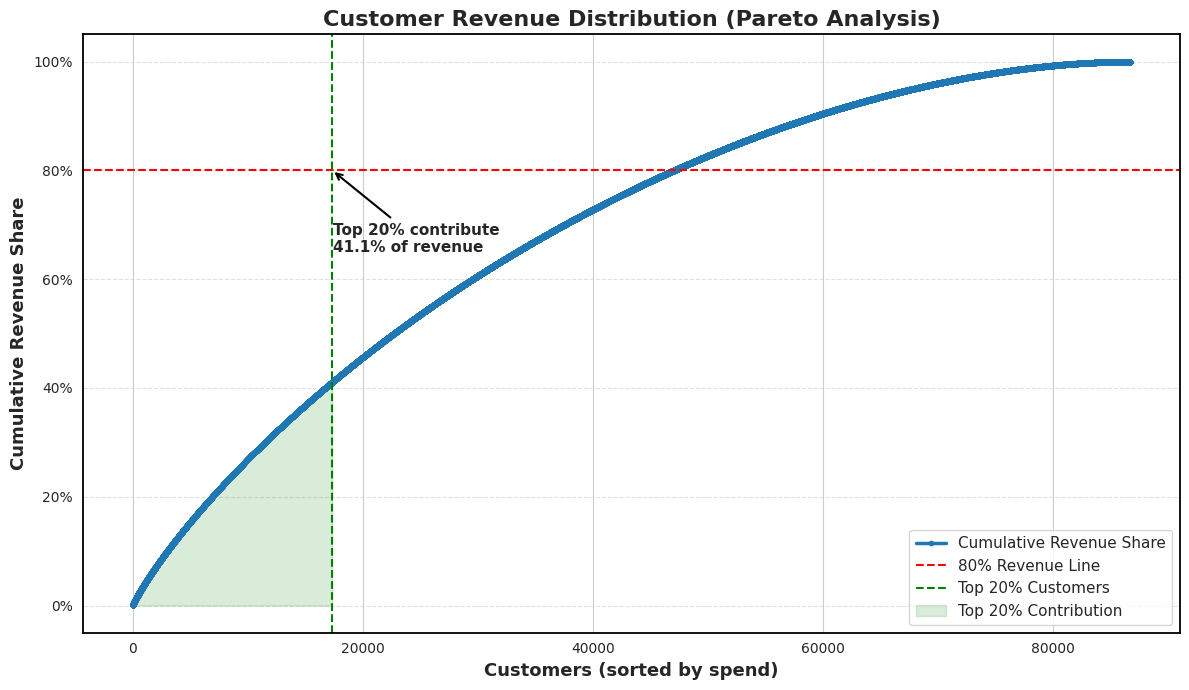

In [10]:
#8 Customer Revenue Distribution (Pareto Analysis)
customer_sales = edf.groupby("Customer_ID")["Total_Amount"].sum().reset_index()
customer_sales = customer_sales.sort_values("Total_Amount", ascending=False)
customer_sales["CumRevenueShare"] = customer_sales["Total_Amount"].cumsum() / customer_sales["Total_Amount"].sum()

top20_threshold = int(0.2 * len(customer_sales))
top20_contribution = customer_sales.head(top20_threshold)["Total_Amount"].sum() / customer_sales["Total_Amount"].sum() * 100
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(
    range(len(customer_sales)),
    customer_sales["CumRevenueShare"],
    color="#1f77b4", linewidth=2.5, marker="o", markersize=3,
    label="Cumulative Revenue Share"
)

ax.axhline(0.8, color="red", linestyle="--", linewidth=1.5, label="80% Revenue Line")

ax.axvline(top20_threshold, color="green", linestyle="--", linewidth=1.5, label="Top 20% Customers")

ax.fill_between(
    range(top20_threshold),
    customer_sales["CumRevenueShare"].iloc[:top20_threshold],
    color="green", alpha=0.15, label="Top 20% Contribution"
)

ax.set_title("Customer Revenue Distribution (Pareto Analysis)", fontsize=16, fontweight="bold")
ax.set_xlabel("Customers (sorted by spend)", fontsize=13, fontweight="bold")
ax.set_ylabel("Cumulative Revenue Share", fontsize=13, fontweight="bold")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y*100:.0f}%"))

ax.annotate(
    f"Top 20% contribute\n{top20_contribution:.1f}% of revenue",
    xy=(top20_threshold, 0.8),
    xytext=(top20_threshold+100, 0.65),
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
    fontsize=11, fontweight="bold")


ax.grid(axis="y", linestyle="--", alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.3)

ax.legend(loc="lower right", fontsize=11)
plt.grid(True, axis='x')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


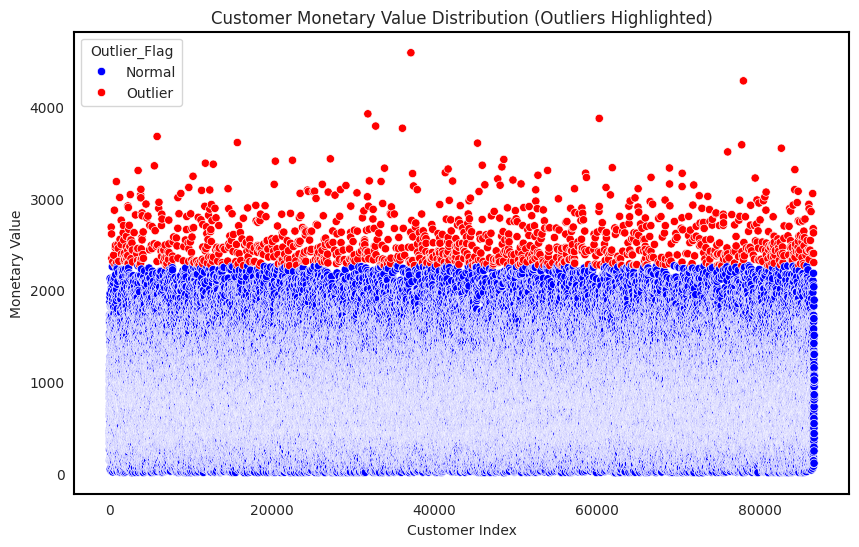

In [11]:
#9 Customer Monetary Value Distribution (Outliers Highlighted) (IQR method)

customer_value = df.groupby('Customer_ID')['Amount'].sum().reset_index()
customer_value = customer_value.rename(columns={'Amount': 'Monetary_Value'})

Q1 = customer_value["Monetary_Value"].quantile(0.25)
Q3 = customer_value["Monetary_Value"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

customer_value["Outlier_Flag"] = customer_value["Monetary_Value"].apply(
    lambda x: "Outlier" if x < lower_bound or x > upper_bound else "Normal"
)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=customer_value,
    x=range(len(customer_value)),
    y="Monetary_Value",
    hue="Outlier_Flag",
    palette={"Normal": "blue", "Outlier": "red"}
)
plt.title("Customer Monetary Value Distribution (Outliers Highlighted)")
plt.xlabel("Customer Index")
plt.ylabel("Monetary Value")
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.show()

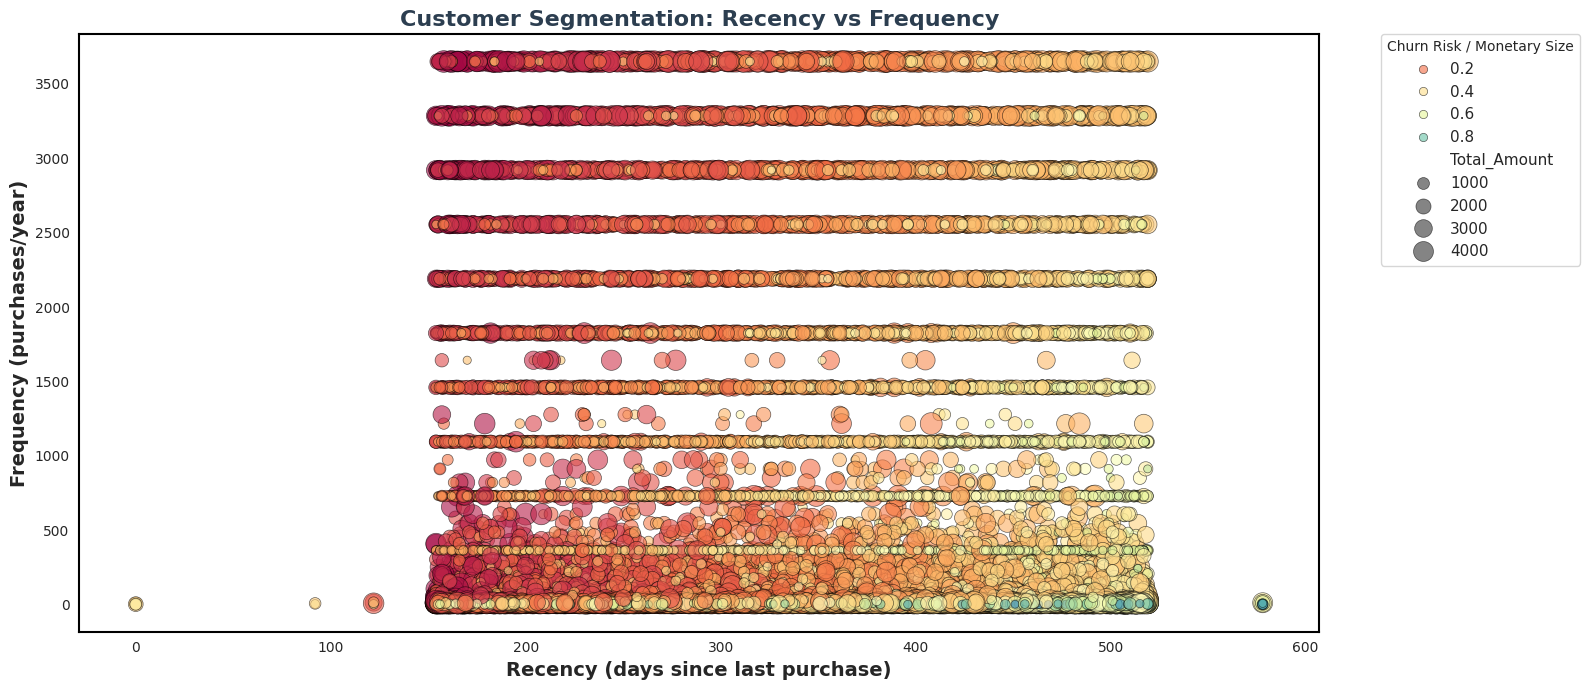

In [12]:
#10 Customer Segmentation (Recency vs. Frequency)
sns.set_style("whitegrid")
plt.figure(figsize=(16,7))

scatter = sns.scatterplot(
    x="Recency",
    y="Frequency",
    size="Total_Amount",
    hue="ChurnRiskScore",
    data=df,
    palette="Spectral",
    alpha=0.6,
    sizes=(30, 250),
    edgecolor='k',
    linewidth=0.5
)

plt.title("Customer Segmentation: Recency vs Frequency", fontsize=16, fontweight='bold', color="#2c3e50")
plt.xlabel("Recency (days since last purchase)", fontsize=14, fontweight='bold')
plt.ylabel("Frequency (purchases/year)", fontsize=14, fontweight='bold')

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title="Churn Risk / Monetary Size", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=11)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.tight_layout()
plt.show()


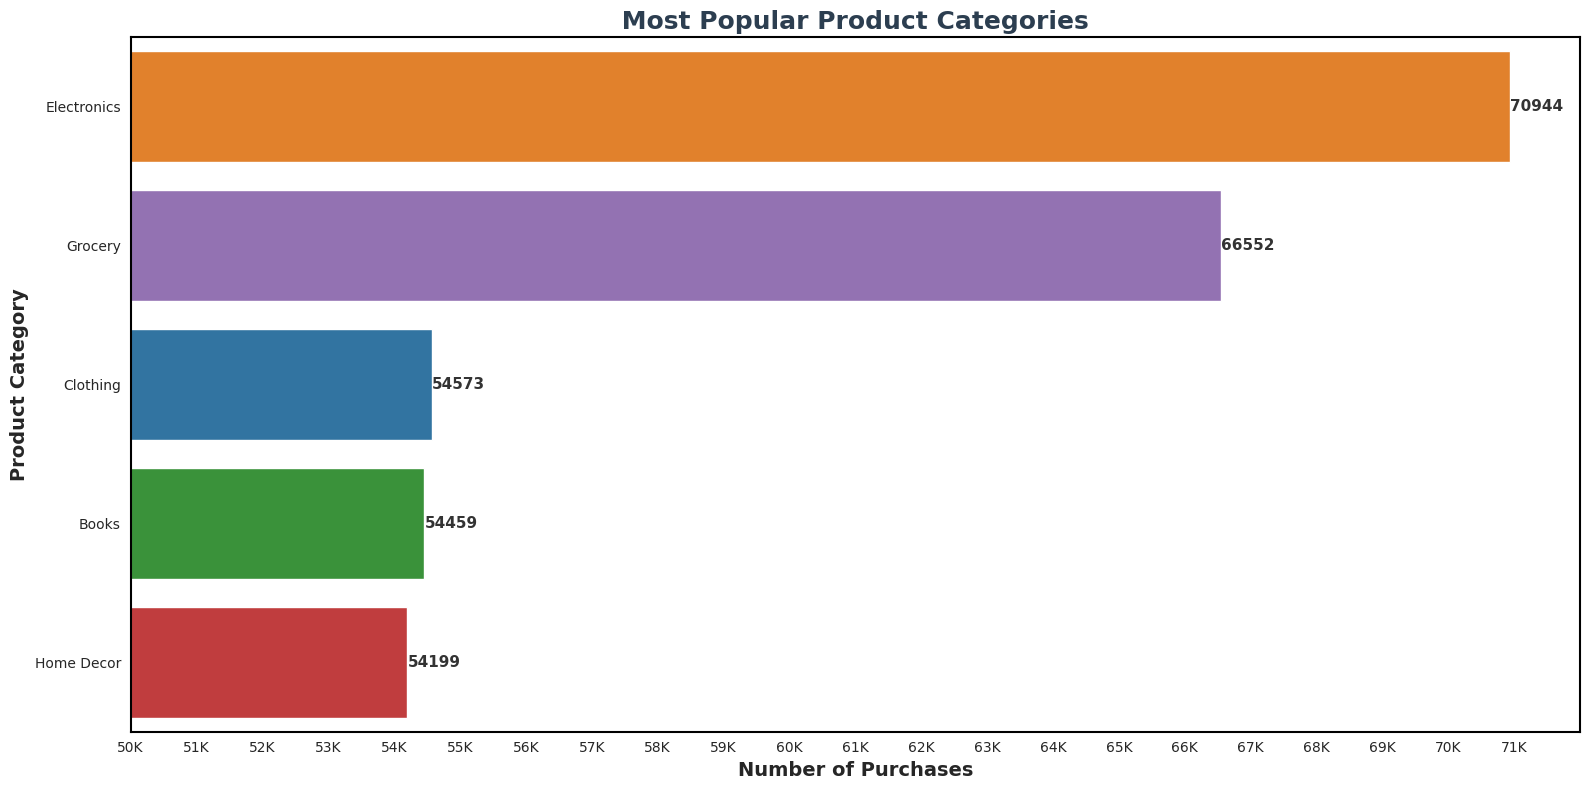

In [13]:

#11 Most Popular Product Categories
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.figure(figsize=(16,8))
ax = sns.countplot(
    y="Product_Category",
    data=df,
    order=df['Product_Category'].value_counts().index,
    palette=sns.color_palette("tab10", n_colors=df['Product_Category'].nunique()),
    hue="Product_Category",
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height()/2, f'{int(width)}', va='center', fontsize=11, fontweight='bold', color="#333333")

plt.title(" Most Popular Product Categories ", fontsize=18, fontweight='bold', color="#2c3e50")
plt.xlabel("Number of Purchases", fontsize=14, fontweight='bold')
plt.ylabel("Product Category", fontsize=14, fontweight='bold')

ax.set_xlim(50000, 72000)
xticks = list(np.arange(50000, 72000, 1000))
ax.set_xticks(xticks)
formatter = mticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K')
ax.xaxis.set_major_formatter(formatter)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.grid(False, axis='x')
plt.grid(False, axis='y')
plt.tight_layout()
plt.show()


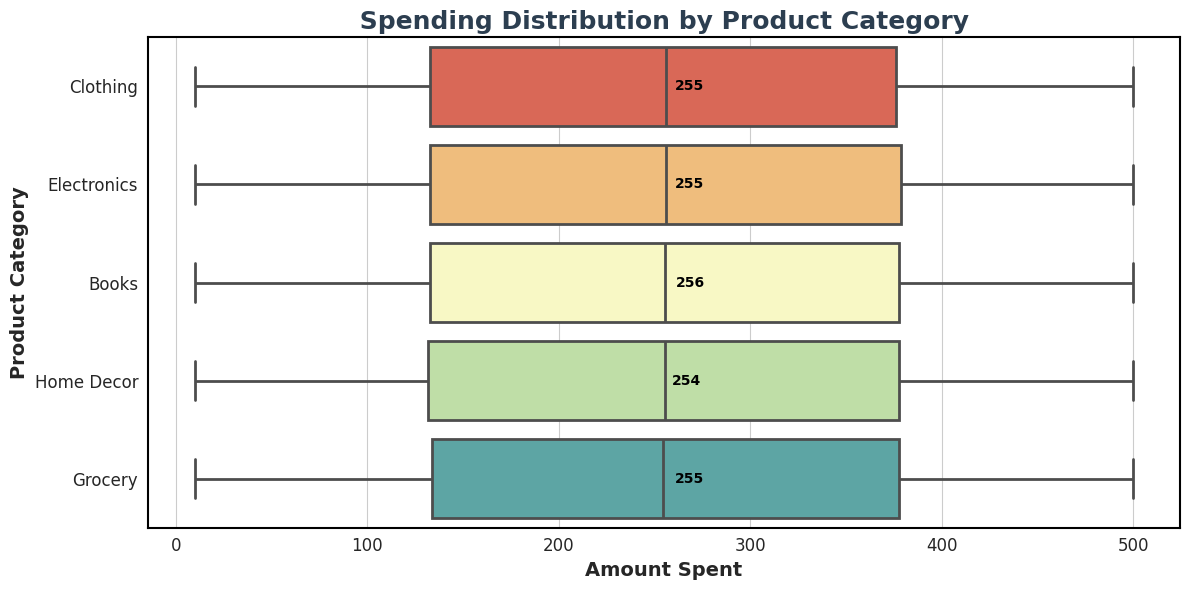

In [14]:
#12 Spending Distribution by Product Category
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

sns.boxplot(
    y="Product_Category",
    x="Amount",
    data=df,
    palette="Spectral",
    linewidth=2,
    fliersize=5,
    saturation=0.8,
    hue="Product_Category",
    legend=False
)

plt.title(" Spending Distribution by Product Category ", fontsize=18, fontweight='bold', color="#2c3e50")
plt.xlabel("Amount Spent", fontsize=14, fontweight='bold')
plt.ylabel("Product Category", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

medians = df.groupby('Product_Category')['Amount'].median()
for i, median in enumerate(medians):
    plt.text(median + max(df['Amount'])*0.01, i, f'{int(median)}', va='center', fontweight='bold', color='black')

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()


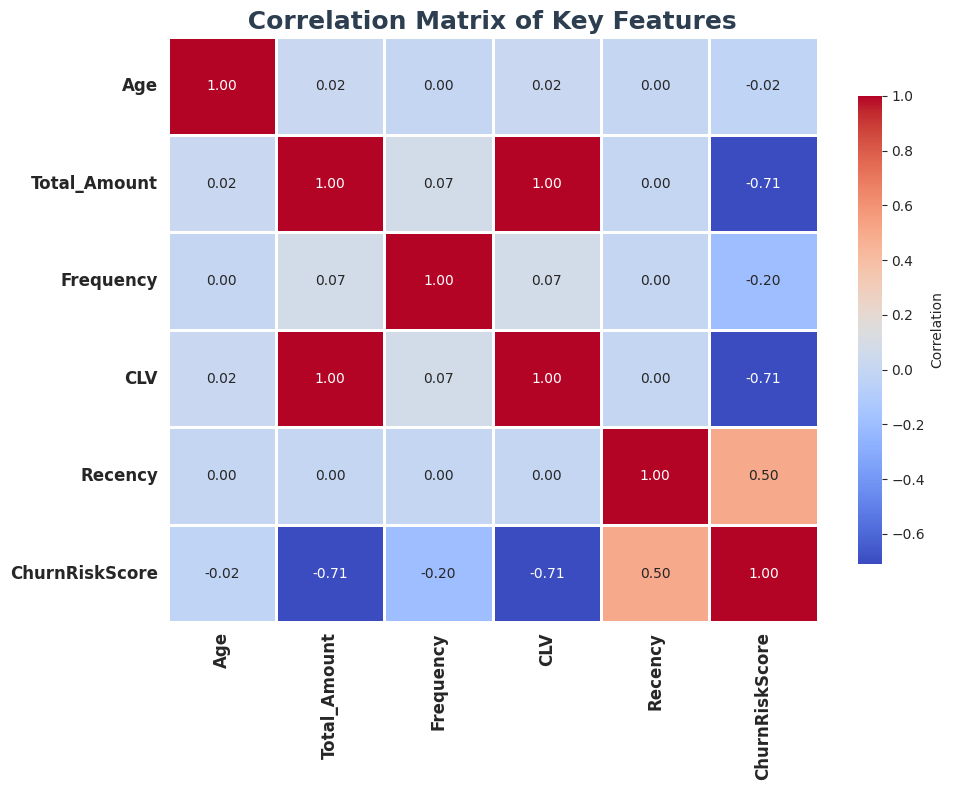

In [15]:


#13 Correlation Matrix
cols = ['Age','Total_Amount','Frequency','CLV','Recency','ChurnRiskScore']
corr = df[cols].corr()

sns.set_style("white")
plt.figure(figsize=(10,8))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.8,
    linecolor='white',
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title(" Correlation Matrix of Key Features ", fontsize=18, fontweight='bold', color="#2c3e50")
plt.xticks(rotation=90, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

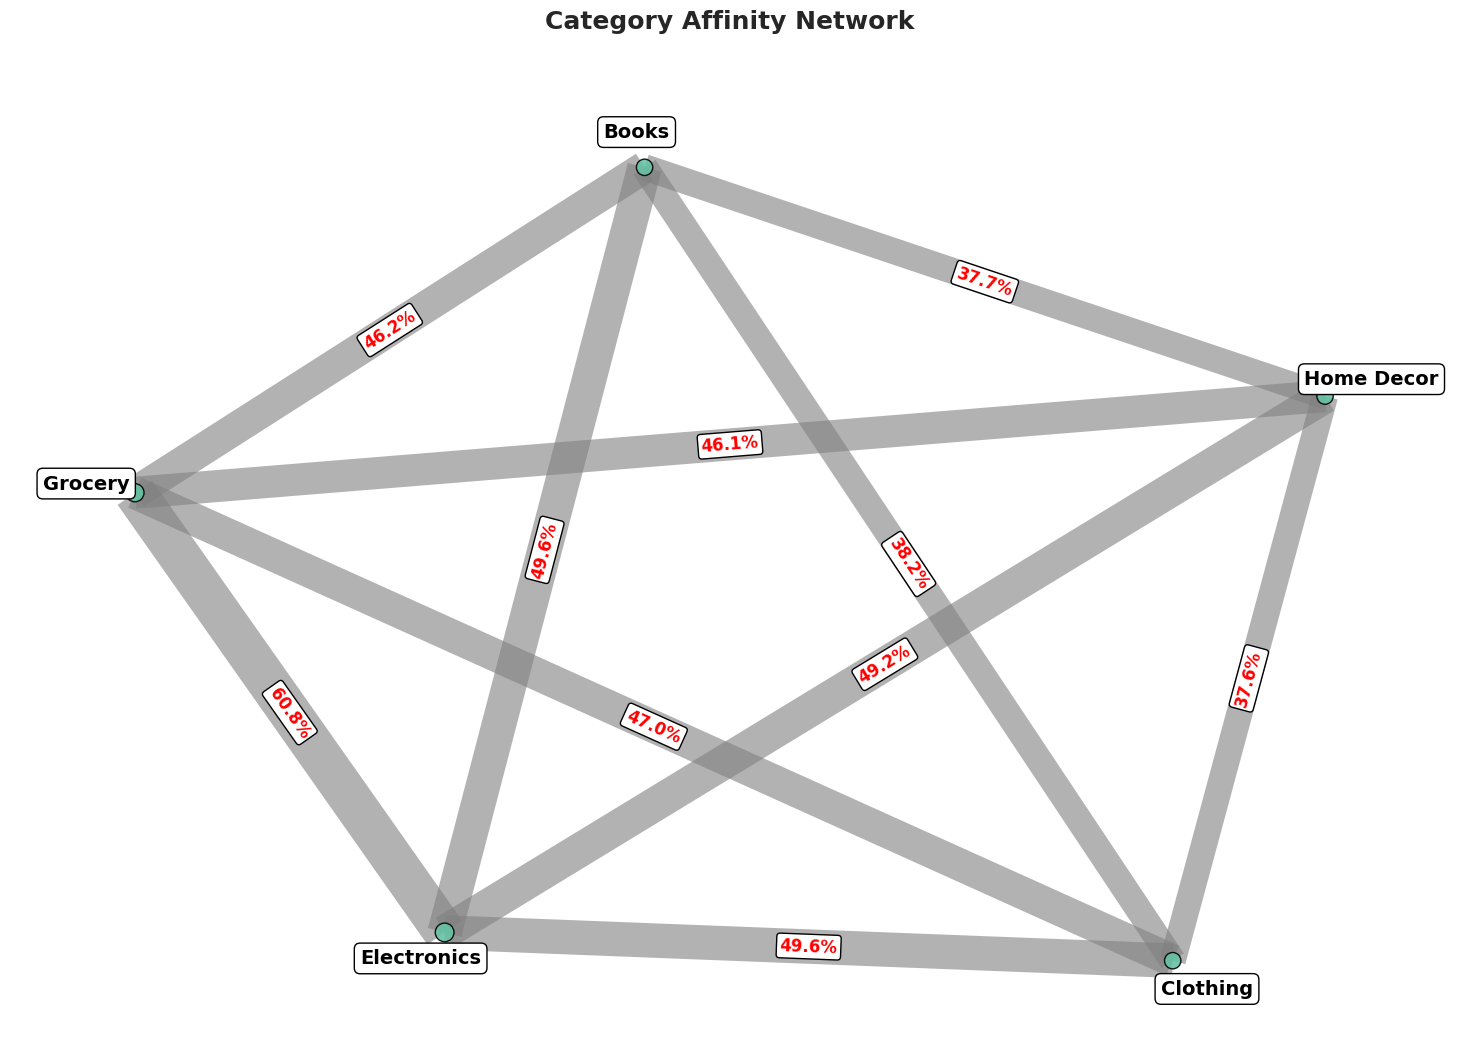

In [16]:
#14 Category Affinity Network (Manual Position Adjustments)

customer_cat = df.groupby(['Customer_ID', 'Product_Category']).size().unstack(fill_value=0)

co_matrix = (customer_cat.T @ customer_cat)
np.fill_diagonal(co_matrix.values, 0)
co_matrix = co_matrix / customer_cat.shape[0]

category_revenue = df.groupby("Product_Category")["Amount"].sum()

G = nx.Graph()

for cat in co_matrix.columns:
    G.add_node(cat, size=category_revenue.get(cat, 0))

for i in co_matrix.index:
    for j in co_matrix.columns:
        if i < j and co_matrix.loc[i, j] > 0:
            G.add_edge(i, j, weight=co_matrix.loc[i, j])

partition = community_louvain.best_partition(G, weight="weight")
colors = [partition[node] for node in G.nodes]

plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G, k=0.4, seed=42)

if "Grocery" in pos:
    pos["Grocery"][1] += 0.1
if "Home Decor" in pos:
    pos["Home Decor"][1] += 0.1

node_sizes = [G.nodes[n]['size'] / 1e5 for n in G.nodes]
edge_widths = [d['weight'] * 50 for _, _, d in G.edges(data=True)]

nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=colors,
    cmap=plt.cm.Set2,
    alpha=0.9,
    edgecolors="black"
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color="gray",
    alpha=0.6
)

label_pos = {}
for k, (x, y) in pos.items():
    label_pos[k] = (x * 1.08, y * 1.08)

nx.draw_networkx_labels(
    G, label_pos,
    font_size=14,
    font_weight="bold",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

edge_labels = {(u, v): f"{d['weight']*100:.1f}%"
               for u, v, d in G.edges(data=True)}

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=12,
    font_color="red",
    font_weight="bold",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2")
)

plt.title("Category Affinity Network",
          fontsize=18, fontweight="bold", pad=40)

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)
plt.axis("off")
plt.show()


In [17]:
#15 Order Status Distribution by Shipping Method
pivot_table = df.groupby(['Shipping_Method', 'Order_Status']).size().unstack(fill_value=0)

custom_green = [
    [0.0, "#e6f5d0"],
    [0.3, "#a1d99b"],
    [0.6, "#31a354"],
    [1.0, "#006d2c"]
]

heatmap_trace = go.Heatmap(
    z=pivot_table.values,
    x=pivot_table.columns,
    y=pivot_table.index,
    colorscale=custom_green,
    text=pivot_table.values,
    texttemplate="%{text}",
    showscale=True,
    colorbar=dict(
        title="Count",
        x=0.46,
        xanchor="left"
    )
)

shipping_status = df.groupby(['Shipping_Method', 'Order_Status']).size().reset_index(name='Count')
sunburst_fig = px.sunburst(
    shipping_status,
    path=['Shipping_Method', 'Order_Status'],
    values='Count',
    color='Shipping_Method',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig = make_subplots(rows=1, cols=2, subplot_titles=("Heatmap", "Pie Chart"),
                    specs=[[{"type": "xy"}, {"type": "domain"}]])

fig.add_trace(heatmap_trace, row=1, col=1)

for trace in sunburst_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    height=600, width=1200,
    title_text="Order Status Distribution by Shipping Method",
    coloraxis=None
)
fig.show()
